In [1]:
import numpy as np
from astropy.io import fits
from astropy.wcs import WCS
import matplotlib.pyplot as plt

In [2]:
### Define FITS file name and galaxy centre coordinates in pixels
filename = 'RV_masque.fits'
x0, y0 = 311, 316

In [3]:
def calculate_gradient(data, x0, y0, angle_deg):
    '''Calculate gradient along a line passing through the coordinates (x0, y0) of the velocity field.
    Parameter:
    -------------
    data: an array containing the velocity field
    x0: x-coordinate of the kinematic centre
    y0: y-coordinate of the kinematic centre
    angle_deg: angle in degrees
    '''
    # Convert angle to radians
    pa_rad = np.radians(90-angle_deg)

    # Generate points along a line passing through (x0, y0) with angle pa_rad
    line_length = max(data.shape[0], data.shape[1])
    x = np.linspace(x0 - np.cos(pa_rad) * line_length / 2, x0 + np.cos(pa_rad) * line_length / 2, line_length)
    y = np.linspace(y0 - np.sin(pa_rad) * line_length / 2, y0 + np.sin(pa_rad) * line_length / 2, line_length)

    # Round the coordinates to integers (pixel coordinates)
    x_int = np.round(x).astype(int)
    y_int = np.round(y).astype(int)

    # Ensure the coordinates are within the image boundaries
    valid_coords = np.where((x_int >= 0) & (x_int < data.shape[1]) & (y_int >= 0) & (y_int < data.shape[0]))

    x_int = x_int[valid_coords]
    y_int = y_int[valid_coords]

    # Extract non-masked (non-NaN) pixel values along the line
    line_values = data[y_int, x_int]
    valid_values = ~np.isnan(line_values)

    if np.any(valid_values):
        # Calculate the gradient of the line for valid values
        gradient = np.gradient(line_values[valid_values])

        # Return the magnitude of the gradient
        return np.sqrt(gradient[0]**2 + gradient[1]**2)

    return 0  # Return 0 if all values are masked (NaN)

def calculate_pa(fname, x0=None, y0=None):
    '''Calculate the PA of the disk.
    Parameters:
    -----------
    fname: FITS file name of the velocity field
    x0: x-coordinate of the kinematic centre (if not provided, will take the centre coordinates)
    y0: y-coordinate of the kinematic centre (if not provided, will take the centre coordinates)
    '''
    data, hdr = fits.getdata(fname, header=True)
    if not x0:
        x0, y0 = data.shape[1]/2, data.shape[0]/2
        
    # Sample several position angles
    num_angles = 180  # Adjust as needed
    angles = np.linspace(0, 180, num_angles)  # Sample angles from 0 to 180 degrees

    # Calculate gradient for each angle
    gradients = [calculate_gradient(data, x0, y0, angle) for angle in angles]

    # Find the position angle (PA) corresponding to the maximum gradient
    best_pa_deg = angles[np.argmax(gradients)]
    
    # Make the angle relative to receding side
    best_pa_deg = (-best_pa_deg) % 360
    return best_pa_deg

In [4]:
### Calculate and print PA:
best_pa_deg = calculate_pa(filename, x0, y0)
print(f'PA = {round(best_pa_deg):d} deg')

PA = 208 deg


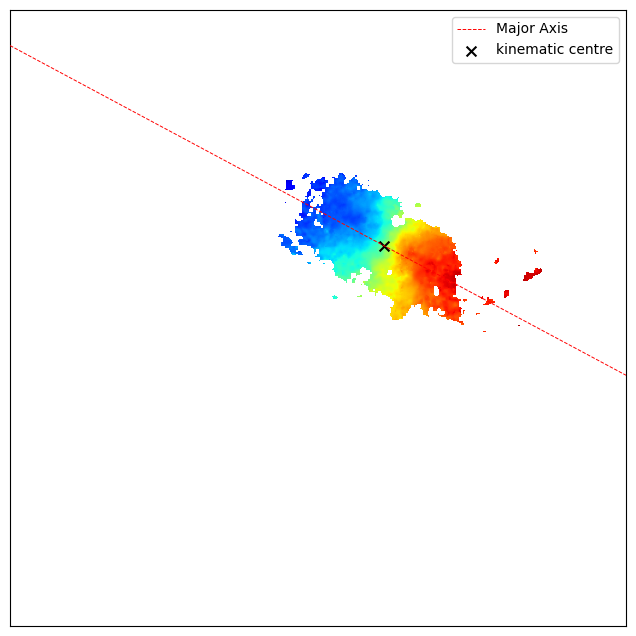

In [5]:
### Plot major axis over velocity field
velocity_field, hdr = fits.getdata(filename, header=True)
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111, projection=WCS(hdr))
# Plot the major axis over the velocity field
ax.imshow(velocity_field, cmap='jet', origin='lower', extent=(0, velocity_field.shape[1], 0, velocity_field.shape[0]))
ax.axline((x0, y0), slope=np.tan(np.radians(-best_pa_deg)), color='r', linestyle='--', lw=0.7, label='Major Axis')
ax.scatter(x0, y0, marker='x', c='k', s=50, label='kinematic centre')
ax.legend(frameon=True)
plt.show()

### The header seems badly defined, it will need to be corrected

In [6]:
hdr

SIMPLE  =                    T / Written by IDL:  Mon Jun 17 15:02:36 2013      
BITPIX  =                  -32 / Number of bits per data pixel                  
NAXIS   =                    2 / Number of data axes                            
NAXIS1  =                  512 /                                                
NAXIS2  =                  512 /                                                
DATE    = '2013-06-17'         / Creation UTC (CCCC-MM-DD) date of FITS header  
COMMENT FITS (Flexible Image Transport System) format is defined in 'Astronomy  
COMMENT and Astrophysics', volume 376, page 359; bibcode 2001A&A...376..359H    
BUNIT   = 'KM/S    '           /                                                
BSCALE  =              1.00000 /                                                
BZERO   =              0.00000 /                                                
CTYPE1  = 'RA---ARC'           /X-axis type                                     
CTYPE2  = 'DEC--ARC'        